In [1]:
import torch
import torchvision
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from captum.attr import IntegratedGradients, Saliency, GradientShap, GuidedBackprop, Deconvolution, InputXGradient, Lime, Occlusion, ShapleyValueSampling, FeatureAblation, KernelShap, NoiseTunnel
from captum.attr import visualization as viz
import random
import pickle
import numpy as np

### Load MNIST Dataset

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:02<00:00, 4598822.64it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 2221817.17it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 9130347.66it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
random.seed(10)
# 10 images per class like ImageNet testing
images = {i:[] for i in range(10)}
for t in trainset:
    if len(images[t[1]]) < 10:
        if random.random() < 0.0026:
            images[t[1]].append(t[0])

In [42]:
images = {i:[images[i][j].convert(mode='RGB') for j in range(10)] for i in range(10)}

In [43]:
with open("MNIST/images.pkl", 'wb') as f:
    pickle.dump(images, f)

In [2]:
with open("MNIST/images.pkl", 'rb') as f:
    images = pickle.load(f)

In [45]:
for i in images:
    count = 0
    for img in images[i]:
        img.save(f"MNIST/data/{trainset.classes[i]}-{count}.png")
        count += 1

In [3]:
all_images_original = []
for i in images:
    all_images_original += images[i]

### Do predictions with ResNet18

In [10]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)

### Finetune resnet to work with MNIST
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [11]:
import time
from tempfile import TemporaryDirectory
import os
import torchvision.transforms.v2 as transforms

In [12]:
model.fc = torch.nn.Linear(512, 10, bias=True)

In [13]:
# Transformations applied to images before passing them to the model
# Pretrained normalization based on https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
means, stds = [0.485, 0.456, 0.406], [0.485, 0.456, 0.406]
means, stds = np.array(means), np.array(stds)

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToImage(), # Converts to tensor
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=means, std=stds)
    ]
)
pipeline = lambda images: torch.stack([transform(image) for image in images])

In [14]:
batch_size = 64
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

model.cuda()
criterion = torch.nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in trainloader:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(trainset)
                epoch_acc = running_corrects.double() / len(trainset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [15]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0674 Acc: 0.9795
val Loss: 0.0440 Acc: 0.9867

Epoch 1/9
----------
train Loss: 0.0341 Acc: 0.9897
val Loss: 0.0246 Acc: 0.9930

Epoch 2/9
----------
train Loss: 0.0255 Acc: 0.9924
val Loss: 0.0150 Acc: 0.9956

Epoch 3/9
----------
train Loss: 0.0220 Acc: 0.9933
val Loss: 0.0210 Acc: 0.9933

Epoch 4/9
----------
train Loss: 0.0208 Acc: 0.9932
val Loss: 0.0160 Acc: 0.9950

Epoch 5/9
----------
train Loss: 0.0158 Acc: 0.9950
val Loss: 0.0133 Acc: 0.9960

Epoch 6/9
----------
train Loss: 0.0129 Acc: 0.9961
val Loss: 0.0097 Acc: 0.9967

Epoch 7/9
----------
train Loss: 0.0047 Acc: 0.9984
val Loss: 0.0015 Acc: 0.9997

Epoch 8/9
----------
train Loss: 0.0020 Acc: 0.9995
val Loss: 0.0009 Acc: 0.9998

Epoch 9/9
----------
train Loss: 0.0014 Acc: 0.9997
val Loss: 0.0006 Acc: 0.9999

Training complete in 23m 13s
Best val Acc: 0.999933


RuntimeError: File MNIST cannot be opened.

In [16]:
torch.save(model.state_dict(), "MNIST/model.pt")

In [17]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
proper_data = pipeline(all_images_original)
model.cpu()
outputs = model(proper_data)
_, preds = torch.max(outputs, 1)
probs = torch.nn.functional.softmax(outputs, dim=1)

In [20]:
torch.save(proper_data, "MNIST/proper_data.pt")
torch.save(preds, "MNIST/preds.pt")

In [22]:
proper_data = torch.load("MNIST/proper_data.pt")
preds = torch.load("MNIST/preds.pt")

### Single Explanations

In [23]:
single_pred = preds[2].unsqueeze(dim=0)
single_data = proper_data[2].unsqueeze(dim=0)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(single_data, target=single_pred, n_steps=200)

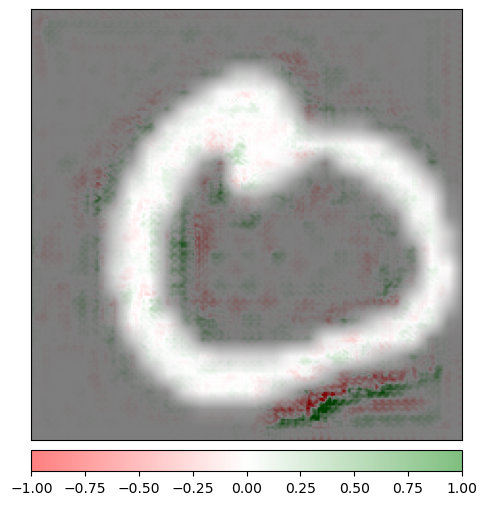

In [24]:
transformed_img = transform(all_images_original[2])

_ = viz.visualize_image_attr(
    attributions_ig.permute(0, 2, 3, 1).tolist()[0],
    transformed_img.permute(1, 2, 0).tolist(),
    method="blended_heat_map",
    sign="all",
    show_colorbar=True
)

### Multiple explanations

In [25]:
multiple_pred = preds[0:2]
multiple_data = proper_data[0:2]
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(multiple_data, target=multiple_pred, n_steps=200)

In [26]:
attributions_ig.shape

torch.Size([2, 3, 224, 224])

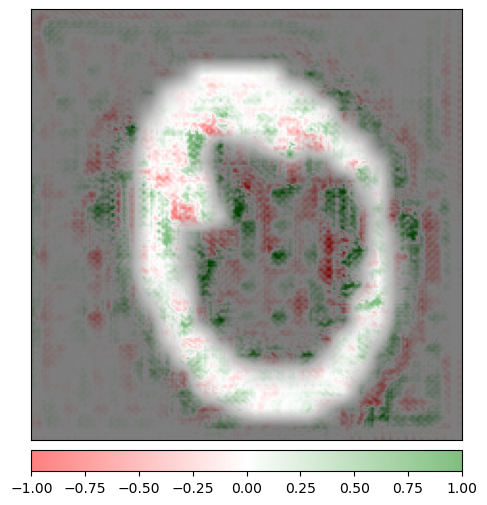

In [27]:
transformed_img = transform(all_images_original[0])

_ = viz.visualize_image_attr(
    attributions_ig.permute(0, 2, 3, 1).tolist()[0],
    transformed_img.permute(1, 2, 0).tolist(),
    method="blended_heat_map",
    sign="all",
    show_colorbar=True
)

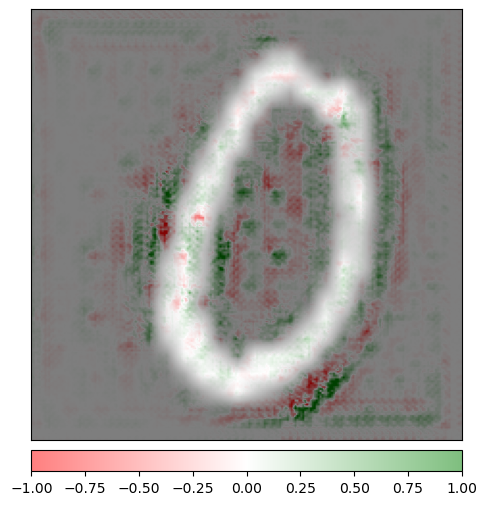

In [28]:
transformed_img = transform(all_images_original[1])

_ = viz.visualize_image_attr(
    attributions_ig.permute(0, 2, 3, 1).tolist()[1],
    transformed_img.permute(1, 2, 0).tolist(),
    method="blended_heat_map",
    sign="all",
    show_colorbar=True
)

### Create superpixels
Reference: https://www.kaggle.com/code/sukanyabag/lime-model-explainability-testing-pytorch and https://github.com/marcotcr/lime/blob/master/lime/lime_image.py

In [29]:
from skimage.segmentation import quickshift
import matplotlib.pyplot as plt
import numpy as np

In [30]:
proper_masks = [quickshift(image, kernel_size=4, max_dist=200, ratio=0.2, channel_axis=0) for image in proper_data]

In [31]:
proper_masks = [torch.tensor(m).unsqueeze(0) for m in proper_masks]

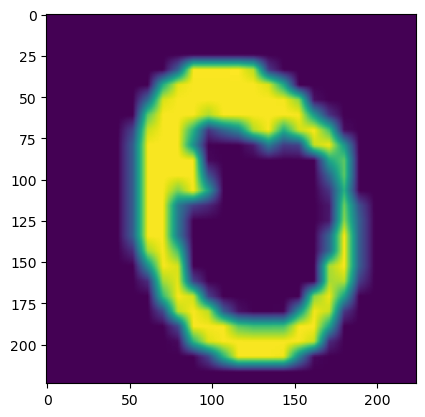

In [32]:
plt.imshow(proper_data[0][0])

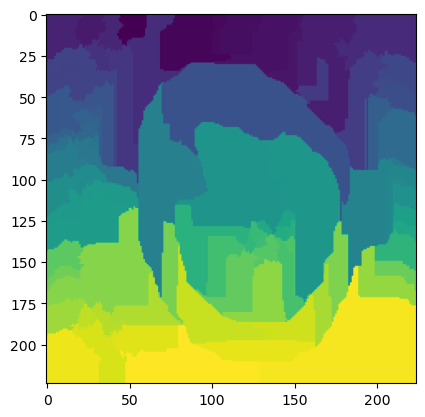

In [33]:
plt.imshow(proper_masks[0][0])

In [34]:
proper_masks = torch.stack(proper_masks)

In [36]:
torch.save(proper_masks, "MNIST/proper_masks.pt")

### Attributions (default parameters)

In [37]:
# Load tensors
proper_data = torch.load("MNIST/proper_data.pt").cuda()
preds = torch.load("MNIST/preds.pt").cuda()
proper_masks = torch.load("MNIST/proper_masks.pt").cuda()

In [38]:
def get_attributions(explainer, num_batches = 50):
    attributions = None
    for i in range(num_batches):
        batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
        if attributions is None:
            attributions = explainer.attribute(proper_data[batch_slice], target=preds[batch_slice])
        else:
            temp = explainer.attribute(proper_data[batch_slice], target=preds[batch_slice])
            attributions = torch.cat((attributions, temp), dim = 0)
    return attributions

In [39]:
model_cuda = model.cuda()

In [40]:
%%time
integrated_gradients = IntegratedGradients(model_cuda)
attributions_ig = get_attributions(integrated_gradients)
torch.save(attributions_ig, "MNIST/attributions_ig.pt")

CPU times: total: 1.7 s
Wall time: 4.63 s


In [41]:
%%time
saliency = Saliency(model_cuda)
attributions_s = get_attributions(saliency)
torch.save(attributions_s, "MNIST/attributions_s.pt")

c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


CPU times: total: 172 ms
Wall time: 460 ms


In [42]:
num_batches = 50

In [43]:
%%time
gradient_shap = GradientShap(model_cuda)
attributions_gs = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_gs is None:
        attributions_gs = gradient_shap.attribute(proper_data[batch_slice].cuda(), torch.zeros_like(proper_data[0:1]), target=preds[batch_slice].cuda())
    else:
        temp = gradient_shap.attribute(proper_data[batch_slice].cuda(), torch.zeros_like(proper_data[0:1]), target=preds[batch_slice].cuda())
        attributions_gs = torch.cat((attributions_gs, temp), dim = 0)

torch.save(attributions_gs, "MNIST/attributions_gs.pt")

CPU times: total: 203 ms
Wall time: 781 ms


In [44]:
%%time
guided_backprop = GuidedBackprop(model_cuda)
attributions_gb = get_attributions(guided_backprop)
torch.save(attributions_gb, "MNIST/attributions_gb.pt")

c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


CPU times: total: 78.1 ms
Wall time: 456 ms


In [45]:
%%time
deconvolution = Deconvolution(model_cuda)
attributions_d = get_attributions(deconvolution)
torch.save(attributions_d, "MNIST/attributions_d.pt")

CPU times: total: 93.8 ms
Wall time: 452 ms


In [46]:
%%time
input_x_gradient = InputXGradient(model_cuda)
attributions_ixg = get_attributions(input_x_gradient)
torch.save(attributions_ixg, "MNIST/attributions_ixg.pt")

CPU times: total: 78.1 ms
Wall time: 341 ms


In [47]:
%%time
# Need feature mask
lime = Lime(model_cuda)
attributions_l = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_l is None:
        attributions_l = lime.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
    else:
        temp = lime.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
        attributions_l = torch.cat((attributions_l, temp), dim = 0)

torch.save(attributions_l, "MNIST/attributions_l.pt")

c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to com

CPU times: total: 1.2 s
Wall time: 9.29 s


In [48]:
%%time
occulsion = Occlusion(model_cuda)
attributions_o = None

# Using sliding window size (3, 15, 15) and strides = (3, 8, 8) as used in EnsembleXAI
for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_o is None:
        attributions_o = occulsion.attribute(proper_data[batch_slice].cuda(), (3, 15, 15), target=preds[batch_slice].cuda(), strides = (3, 8, 8))
    else:
        temp = occulsion.attribute(proper_data[batch_slice].cuda(), (3, 15, 15), target=preds[batch_slice].cuda(), strides = (3, 8, 8))
        attributions_o = torch.cat((attributions_o, temp), dim = 0)

torch.save(attributions_o, "MNIST/attributions_o.pt")

CPU times: total: 9.56 s
Wall time: 1min 38s


In [49]:
%%time
# Need feature mask
shapley_value_sampling = ShapleyValueSampling(model_cuda)
attributions_svs = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_svs is None:
        attributions_svs = shapley_value_sampling.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
    else:
        temp = shapley_value_sampling.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
        attributions_svs = torch.cat((attributions_svs, temp), dim = 0)

torch.save(attributions_svs, "MNIST/attributions_svs.pt")

CPU times: total: 55.2 s
Wall time: 8min 15s


In [50]:
%%time
# Need feature mask
feature_ablation = FeatureAblation(model_cuda)
attributions_fa = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_fa is None:
        attributions_fa = feature_ablation.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
    else:
        temp = feature_ablation.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
        attributions_fa = torch.cat((attributions_fa, temp), dim = 0)

torch.save(attributions_fa, "MNIST/attributions_fa.pt")

CPU times: total: 3.8 s
Wall time: 22.5 s


In [51]:
%%time
# Need feature mask
kernel_shap = KernelShap(model_cuda)
attributions_ks = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_ks is None:
        attributions_ks = kernel_shap.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
    else:
        temp = kernel_shap.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
        attributions_ks = torch.cat((attributions_ks, temp), dim = 0)

torch.save(attributions_ks, "MNIST/attributions_ks.pt")

c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to com

CPU times: total: 1.09 s
Wall time: 9.22 s


In [52]:
%%time
noise_tunnel = NoiseTunnel(integrated_gradients) # base on EnsembleXAI
attributions_nt = get_attributions(noise_tunnel, num_batches = 100)
torch.save(attributions_nt, "MNIST/attributions_nt.pt")

CPU times: total: 4.44 s
Wall time: 20.3 s


### Normalization

In [53]:
from EnsembleXAI.Normalization import mean_var_normalize

In [54]:
attributions = {
    'attributions_ig': torch.load('CIFAR10/attributions_ig.pt'),
    'attributions_s': torch.load('CIFAR10/attributions_s.pt'),
    'attributions_gs': torch.load('CIFAR10/attributions_gs.pt'),
    'attributions_gb': torch.load('CIFAR10/attributions_gb.pt'),
    'attributions_d': torch.load('CIFAR10/attributions_d.pt'),
    'attributions_ixg': torch.load('CIFAR10/attributions_ixg.pt'),
    'attributions_l': torch.load('CIFAR10/attributions_l.pt'),
    'attributions_o': torch.load('CIFAR10/attributions_o.pt'),
    'attributions_svs': torch.load('CIFAR10/attributions_svs.pt'),
    'attributions_fa': torch.load('CIFAR10/attributions_fa.pt'),
    'attributions_ks': torch.load('CIFAR10/attributions_ks.pt'),
    'attributions_nt': torch.load('CIFAR10/attributions_nt.pt'),
}

In [55]:
normalized_attributions = {attr: mean_var_normalize(attributions[attr]) for attr in attributions}

### EnsembleXAI

In [56]:
from EnsembleXAI.Ensemble import normEnsembleXAI

In [57]:
explanations = torch.stack([normalized_attributions[attr] for attr in normalized_attributions], dim=1)

In [58]:
agg = normEnsembleXAI(explanations.detach(), aggregating_func='avg')

In [59]:
torch.save(agg, "MNIST/agg.pt")

### Ground truth masks

In [67]:
transformed = []
count = 0
for img in proper_data.cpu():
    temp = img[0]
    values = temp.unique().tolist()
    # sometimes there are no 0's
    temp.apply_(lambda val: 0 != values.index(val))
    transformed.append(temp.int())
    count += 1

ground_truth_masks = torch.stack(transformed)

In [68]:
torch.save(ground_truth_masks, "MNIST/ground_truth_masks.pt")